In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

import sys
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path

['/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/python',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib',
 '',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages',
 '/cvmfs/sft.cern.ch/lcg/releases/LCG_97python3/Python/3.7.6/x86_64-centos7-gcc8-opt/lib/python37.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/LCG_97python3/Python/3.7.6/x86_64-centos7-gcc8-opt/lib/python3.7',
 '/cvmfs/sft.cern.ch/lcg/releases/LCG_97python3/Python/3.7.6/x86_64-centos7-gcc8-opt/lib/python3.7/lib-dynload',
 '/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/extensions',
 '/scratch/antoniov/.ipython']

In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

run_tables = False

use_keras = True

if use_keras:
    # DNN
    #prob_cut = 0.1339 # TPR ~95%
    prob_cut = 0.2637 # TPR ~90%
    #prob_cut = 0.4260 # TPR ~85%
    #prob_cut = 0.6445 # TPR ~75%
    #prob_cut = 0.75
    #prob_cut = 0.2815 # FPR ~0.05%
else:
    # BDT
    #prob_cut = 0.2764 # TPR ~95% 
    prob_cut = 0.6497 # TPR ~90%
    #prob_cut = 0.6910
    #prob_cut = 0.2764 # FPR ~0.05%
print ( prob_cut )

{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966
0.2637


### Load classifier

In [3]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf
from tensorflow import keras
print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

#clf = load( "model/ada_clf.joblib" )
#clf = load( "model/adaboost_clf_test-multiRP_2021_01_14-21_04_56.joblib" )
scaler = None
clf = None
if use_keras:
    scaler_path = "model/standard_scaler_test-multiRP_2021_01_22-17_27_08.joblib"
    model_path = "model/keras_model_test-multiRP_2021_01_22-17_46_10.h5"
    scaler = load( scaler_path )
    clf = keras.models.load_model( model_path )
else:
    model_path = "model/adaboost_clf_test-multiRP_2021_01_14-21_04_56.joblib"
    clf = load( model_path )
print( clf )

sklearn: 0.23.2
tensorflow: 2.3.1


### Signal

In [4]:
#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/02/04 10:57:28
Total time elapsed: 0
2021/02/04 10:57:28
Total time elapsed: 0
2021/02/04 10:57:28
Total time elapsed: 0


In [5]:
#df_protons_multiRP_signal_index[:20]

df_signals_protons_multiRP_index[ "GGToWW-AQGC-A0W5e-6" ][:20]

xi       thx       thy         t  ismultirp  \
run lumiblock event  slice                                                      
1   6049      104823 0      0.040114  0.000016 -0.000033 -0.055696          1   
                     0      0.183088 -0.000107  0.000127 -0.986969          1   
              104872 0      0.085650 -0.000082 -0.000057 -0.392038          1   
                     0      0.044953 -0.000032 -0.000003 -0.043198          1   
    6051      105004 0      0.070999 -0.000085  0.000022 -0.306888          1   
                     0      0.065987  0.000072  0.000030 -0.241601          1   
              105026 0      0.046328 -0.000019 -0.000024 -0.038161          1   
                     0      0.149583 -0.000080  0.000078 -0.471365          1   
              105090 0      0.124829 -0.000117 -0.000037 -0.570310          1   
                     0      0.091662  0.000042 -0.000034 -0.118994          1   
    6052      105102 0      0.040554  0.000034 -0.000030 -0.084765          1   
                     0      0.038650  0.000057  0.000003 -0.134480          1   
              105168 0      0.107580  0.000026  0.000030 -0.070771          1   
                     0      0.166825 -0.000052  0.000065 -0.275437          1   
    6055      105434 0      0.122439  0.000020  0.000154 -0.913376          1   
                     0      0.071999  0.000036 -0.000082 -0.319079          1   
              105438 0      0.116528 -0.000081  0.000047 -0.337760          1   
                     0      0.090337 -0.000026 -0.000018 -0.045839          1   
    6056      105583 0      0.077867 -0.000013 -0.000030 -0.046573          1   
                     0      0.123415  0.000080  0.000022 -0.269354          1   

                            rpid  arm     jet0_pt  jet0_eta  jet0_phi  ...  \
run lumiblock event  slice                                             ...   
1   6049      104823 0       123    0  452.068115 -1.435060 -2.165500  ...   
                     0       123    1  452.068115 -1.435060 -2.165500  ...   
              104872 0       123    0  293.328430  1.216596 -2.577840  ...   
                     0       123    1  293.328430  1.216596 -2.577840  ...   
    6051      105004 0       123    0  434.371490  0.182227  1.019939  ...   
                     0       123    1  434.371490  0.182227  1.019939  ...   
              105026 0       123    0  465.300446 -1.146430 -1.029243  ...   
                     0       123    1  465.300446 -1.146430 -1.029243  ...   
              105090 0       123    0  722.540283 -0.183093  1.128231  ...   
                     0       123    1  722.540283 -0.183093  1.128231  ...   
    6052      105102 0       123    0  230.141449 -0.358933  0.542338  ...   
                     0       123    1  230.141449 -0.358933  0.542338  ...   
              105168 0       123    0  343.186157  1.413285  0.784215  ...   
                     0       123    1  343.186157  1.413285  0.784215  ...   
    6055      105434 0       123    0  559.050720  0.070478  2.299587  ...   
                     0       123    1  559.050720  0.070478  2.299587  ...   
              105438 0       123    0  636.379700  0.544857 -1.580128  ...   
                     0       123    1  636.379700  0.544857 -1.580128  ...   
    6056      105583 0       123    0  613.628723 -0.823772  0.281126  ...   
                     0       123    1  613.628723 -0.823772  0.281126  ...   

                            yhigh  eff_all_weighted  eff_all_2017B  \
run lumiblock event  slice                                           
1   6049      104823 0      4.298          0.206591       0.418829   
                     0      4.698          0.434932       0.436443   
              104872 0      4.298          0.339722       0.470016   
                     0      4.698          0.071505       0.087529   
    6051      105004 0      4.298          0.341967       0.458852   
                     0      4.698          0

In [6]:
for label_ in labels_signals:
    print ( label_ )
    print ( "Average proton efficiency: {}".format( np.mean( df_signals_protons_multiRP_index[ label_ ].loc[ :, [ "eff_all_weighted" ] ] ) ) )

GGToWW-AQGC-A0W1e-6
Average proton efficiency: eff_all_weighted    0.353368
dtype: float64
GGToWW-AQGC-A0W2e-6
Average proton efficiency: eff_all_weighted    0.369921
dtype: float64
GGToWW-AQGC-A0W5e-6
Average proton efficiency: eff_all_weighted    0.38019
dtype: float64


In [7]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [8]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi/sample_nevents_, sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = np.product( norm_factors[ label_ ] )

37.190432966
[993700.0, 0.0453974, 6]
[3.74262181e-05 4.53974000e+01 1.00000000e+00]
[880000.0, 0.0583158, 6]
[4.22618556e-05 5.83158000e+01 1.00000000e+00]
[993000.0, 0.148132, 6]
[3.74526012e-05 1.48132000e+02 1.00000000e+00]


In [9]:
#df_protons_multiRP_signal_events[:20]

df_signals_protons_multiRP_events[ "GGToWW-AQGC-A0W5e-6" ][:20]

jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   6049      104823 0      452.068115 -1.435060 -2.165500  1008.722229   
              104872 0      293.328430  1.216596 -2.577840   546.527954   
    6051      105004 0      434.371490  0.182227  1.019939   449.743011   
              105026 0      465.300446 -1.146430 -1.029243   809.861145   
              105090 0      722.540283 -0.183093  1.128231   743.254578   
    6052      105102 0      230.141449 -0.358933  0.542338   252.797607   
              105168 0      343.186157  1.413285  0.784215   752.903748   
    6055      105434 0      559.050720  0.070478  2.299587   567.419312   
              105438 0      636.379700  0.544857 -1.580128   739.750488   
    6056      105583 0      613.628723 -0.823772  0.281126   843.196838   
              105577 0      529.907166 -0.247067  1.897167   560.596924   
    6057      105633 0      281.976471  0.539512  1.790467   334.587402   
              105623 0      446.924469 -0.392831  2.540933   497.910034   
              105676 0      470.060974  0.123544 -2.192564   487.995361   
    6058      105779 0      552.083923  0.389342 -0.418603   603.381042   
              105791 0      327.286499  1.283385  0.073566   643.324280   
    6060      105904 0      353.134003  0.496544 -2.046549   407.542847   
              105918 0      566.340149  1.097786  1.758100   949.581116   
              105936 0      477.690643  0.585914 -1.255080   564.718323   
              105982 0      265.334839  0.386013 -2.068118   300.402344   

                            jet0_mass  jet0_corrmass  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                                   
1   6049      104823 0      69.203735      76.355621   0.223470   0.105808   
              104872 0      74.199005      81.271736   0.230915   0.104564   
    6051      105004 0      71.536041      75.429672   0.196847   0.029367   
              105026 0       8.925303       9.765107   0.070950   0.053399   
              105090 0      79.588181      84.074463   0.164181   0.031736   
    6052      105102 0      26.109879      27.588261   0.186563   0.141694   
              105168 0      75.405907      83.015511   0.237006   0.156580   
    6055      105434 0      71.377991      75.296288   0.126026   0.035244   
              105438 0      72.881981      77.138245   0.126937   0.038747   
    6056      105583 0      79.674423      85.219337   0.172636   0.061005   
              105577 0      78.999374      83.462891   0.168828   0.074351   
    6057      105633 0      78.815704      83.194817   0.317612   0.103681   
              105623 0      75.043495      79.385674   0.252133   0.116312   
              105676 0      88.361160      93.209106   0.213981   0.056998   
    6058      105779 0      70.996025      75.075836   0.177632   0.054205   
              105791 0      70.047798      77.286636   0.277817   0.130851   
    6060      105904 0      65.290756      69.058250   0.165595   0.071294   
              105918 0      73.424767      79.837265   0.188871   0.050568   
              105936 0       2.818130       2.981335   0.026323   0.017655   
              105982 0      85.920494      90.678452   0.341819   0.126167   

                            jet0_vertexz    muon0_pt  ...    ylow  yhigh  \
run lumiblock event  slice                            ...                  
1   6049      104823 0               0.0  106.349663  ... -10.098  4.298   
              104872 0               0.0   94.313477  ... -10.098  4.298   
    6051      105004 0               0.0  377.541473  ... -10.098  4.298   
              105026 0               0.0  280.962524  ... -10.098  4.298   
              105090 0               0.0  163.334473  ... -10.098  4.298   
    6052      105102 0               0.0   96.269043  ... -10.098  4.298   
              105168 0               0.0  126.313858  .

In [10]:
for label_ in labels_signals:
    print ( label_ )
    print ( "Average proton efficiency: {}".format( np.mean( df_signals_protons_multiRP_events[ label_ ].loc[ :, [ "eff_all_weighted" ] ] ) ) )

GGToWW-AQGC-A0W1e-6
Average proton efficiency: eff_all_weighted    0.123101
dtype: float64
GGToWW-AQGC-A0W2e-6
Average proton efficiency: eff_all_weighted    0.135507
dtype: float64
GGToWW-AQGC-A0W5e-6
Average proton efficiency: eff_all_weighted    0.14315
dtype: float64


### Background

In [11]:
resample_factor = 20
label = "data-random-resample_20"

fileNames_bkg = [
    "output-data-random-resample_20-2017B.h5",
    "output-data-random-resample_20-2017C.h5",
    "output-data-random-resample_20-2017D.h5",
    "output-data-random-resample_20-2017E.h5",
    "output-data-random-resample_20-2017F.h5"
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = 4 * [None]
df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = 3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = get_data( fileNames_bkg )
        df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = process_data_protons_multiRP( df_protons_multiRP_bkg, df_ppstracks_bkg, apply_fiducial=True, within_aperture=True, random_protons=True, runOnMC=False )

        store_[ "counts" ] = df_counts_bkg
        store_[ "protons_multiRP"] = df_protons_multiRP_bkg_index
        store_[ "events_multiRP" ] = df_protons_multiRP_bkg_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_bkg = store_[ "counts" ]
    df_protons_multiRP_bkg_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_bkg_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/02/04 10:57:29
Total time elapsed: 4


In [12]:
df_protons_multiRP_bkg_index[:20]

xi       thx       thy         t  \
run    lumiblock event     slice                                           
297101 216       302550016 0      0.053462  0.000038 -0.000089 -0.375001   
                           0      0.108715  0.000028 -0.000071 -0.232221   
297292 87        162028576 0      0.041559  0.000090  0.000020 -0.347821   
                           0      0.078012  0.000043 -0.000074 -0.290854   
297050 23        23347598  0      0.039482 -0.000016 -0.000056 -0.137540   
                           0      0.070625  0.000103  0.000083 -0.692292   
       65        78788008  0      0.094874 -0.000006 -0.000094 -0.349458   
                           0      0.088130  0.000026 -0.000054 -0.144942   
       499       605989248 0      0.046020  0.000002  0.000030 -0.037710   
                           0      0.044068  0.000065 -0.000112 -0.680873   
297411 315       507722016 0      0.115323 -0.000139 -0.000009 -0.740176   
                           0      0.084233 -0.000093  0.000012 -0.349463   
       377       608603776 0      0.036584 -0.000039 -0.000136 -0.817616   
                           0      0.045994  0.000036 -0.000064 -0.218576   
297177 103       155861312 0      0.098408 -0.000010 -0.000046 -0.094515   
                           0      0.041949 -0.000018  0.000023 -0.036352   
       112       168879968 0      0.031520  0.000010 -0.000105 -0.458029   
                           0      0.082399  0.000013 -0.000029 -0.044631   
297057 359       451236608 0      0.106113  0.000021  0.000082 -0.282647   
                           0      0.121658 -0.000046  0.000034 -0.137009   

                                  ismultirp  rpid  arm     jet0_pt  jet0_eta  \
run    lumiblock event     slice                                               
297101 216       302550016 0              1   123    0  253.968201 -0.707324   
                           0              1   123    1  253.968201 -0.707324   
297292 87        162028576 0              1   123    0  211.335602  0.778516   
                           0              1   123    1  211.335602  0.778516   
297050 23        23347598  0              1   123    0  261.334717 -1.010473   
                           0              1   123    1  261.334717 -1.010473   
       65        78788008  0              1   123    0  223.571411 -0.640955   
                           0              1   123    1  223.571411 -0.640955   
       499       605989248 0              1   123    0  247.993744 -0.750684   
                           0              1   123    1  247.993744 -0.750684   
297411 315       507722016 0              1   123    0  202.485367 -1.909996   
                           0              1   123    1  202.485367 -1.909996   
       377       608603776 0              1   123    0  241.069107 -0.283513   
                           0              1   123    1  241.069107 -0.283513   
297177 103       155861312 0              1   123    0  205.575821  1.169397   
                           0              1   123    1  205.575821  1.169397   
       112       168879968 0              1   123    0  249.287399 -0.463456   
                           0              1   123    1  249.287399 -0.463456   
297057 359       451236608 0              1   123    0  394.285278  0.398574   
                           0              1   123    1  394.285278  0.398574   

                                  jet0_phi  ...    trackx2   tracky2  \
run    lumiblock event     slice            ...                        
297101 216       302550016 0      2.950644  ...   5.739746  1.239502   
                           0      2.950644  ...   8.485718  4.192871   
297292 87        162028576 0     -2.783820  ...   4.923218 -0.440033   
                           0     -2.783820  ...   6.192932  2.448730   
297050 23        23347598  0      1.135294  ...   3.563660  0.499451   
                           0      1.135294  ...   6.810974 -2.298340   
       65        78788008  0  

In [13]:
df_protons_multiRP_bkg_index[ [ "run_rnd", "lumiblock_rnd", "event_rnd", "slice_rnd",
                                "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm",
                                "trackpixshift1", "rpid1", "trackpixshift2", "rpid2", "trackx1", "trackx2", "tracky1", "tracky2"] ][:20]

run_rnd  lumiblock_rnd  event_rnd  \
run    lumiblock event     slice                                      
297101 216       302550016 0       297101            164  232291296   
                           0       297101            164  232291296   
297292 87        162028576 0       297425             82  130758992   
                           0       297425             82  130758992   
297050 23        23347598  0       297100            271  492839776   
                           0       297100            271  492839776   
       65        78788008  0       297057            389  488075136   
                           0       297057            389  488075136   
       499       605989248 0       297469             61   99042640   
                           0       297469             61   99042640   
297411 315       507722016 0       297057            297  375215616   
                           0       297057            297  375215616   
       377       608603776 0       297292             68  127191856   
                           0       297292             68  127191856   
297177 103       155861312 0       297178            602  769280704   
                           0       297178            602  769280704   
       112       168879968 0       297296            231  335794368   
                           0       297296            231  335794368   
297057 359       451236608 0       297057            353  444560864   
                           0       297057            353  444560864   

                                  slice_rnd        xi       thx       thy  \
run    lumiblock event     slice                                            
297101 216       302550016 0             12  0.053462  0.000038 -0.000089   
                           0             12  0.108715  0.000028 -0.000071   
297292 87        162028576 0             12  0.041559  0.000090  0.000020   
                           0             12  0.078012  0.000043 -0.000074   
297050 23        23347598  0              6  0.039482 -0.000016 -0.000056   
                           0              6  0.070625  0.000103  0.000083   
       65        78788008  0              4  0.094874 -0.000006 -0.000094   
                           0              4  0.088130  0.000026 -0.000054   
       499       605989248 0             18  0.046020  0.000002  0.000030   
                           0             18  0.044068  0.000065 -0.000112   
297411 315       507722016 0             17  0.115323 -0.000139 -0.000009   
                           0             17  0.084233 -0.000093  0.000012   
       377       608603776 0              6  0.036584 -0.000039 -0.000136   
                           0              6  0.045994  0.000036 -0.000064   
297177 103       155861312 0             13  0.098408 -0.000010 -0.000046   
                           0             13  0.041949 -0.000018  0.000023   
       112       168879968 0              0  0.031520  0.000010 -0.000105   
                           0              0  0.082399  0.000013 -0.000029   
297057 359       451236608 0              7  0.106113  0.000021  0.000082   
                           0              7  0.121658 -0.000046  0.000034   

                                         t  ismultirp  rpid  arm  \
run    lumiblock event     slice                                   
297101 216       302550016 0     -0.375001          1   123    0   
                           0     -0.232221          1   123    1   
297292 87        162028576 0     -0.347821          1   123    0   
                           0     -0.290854          1   123    1   
297050 23        23347598  0     -0.137540          1   123    0   
                           0     -0.692292          1   123    1   
       65        78788008  0     -0.349458          1   123    0   
                           0     -0.144942          1   123    1   
       499       605989248 0     -0.037710          1   123    0   
                           0

In [14]:
df_protons_multiRP_bkg_events[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297101 216       302550016  0      253.968201 -0.707324  2.950644   
297292 87        162028576  0      211.335602  0.778516 -2.783820   
297050 23        23347598   0      261.334717 -1.010473  1.135294   
       65        78788008   0      223.571411 -0.640955 -1.560675   
       499       605989248  0      247.993744 -0.750684 -1.880714   
297411 315       507722016  0      202.485367 -1.909996 -2.974470   
       377       608603776  0      241.069107 -0.283513  2.425223   
297177 103       155861312  0      205.575821  1.169397 -2.365454   
       112       168879968  0      249.287399 -0.463456  0.465937   
297057 359       451236608  0      394.285278  0.398574 -1.529445   
297219 2173      3099827968 0      288.619812  0.455739  0.454244   
                 3099778304 0      375.724274  0.520944 -0.466679   
                 3100205568 0      247.402695 -1.569887  0.242396   
297425 58        92710800   0      456.756805 -0.825246  1.224345   
297050 640       759692672  0      356.842926 -1.857062  1.034243   
       658       778318912  0      323.938354 -2.283609  2.840562   
       633       752294720  0      281.741394  1.049507  3.116731   
                 752405312  0      203.592255 -1.403587  1.493702   
       635       754300416  0      278.962280  2.154710 -2.295970   
       634       753442816  0      460.727081  1.591670  1.678488   

                                   jet0_energy   jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                           
297101 216       302550016  0       333.493073   79.504433      85.812309   
297292 87        162028576  0       282.520508   32.382271      34.919926   
297050 23        23347598   0       412.250397   26.409565      28.783287   
       65        78788008   0       276.403442   11.500848      12.381974   
       499       605989248  0       327.492065   37.604755      40.593559   
297411 315       507722016  0       701.777527   37.559608      42.359814   
       377       608603776  0       259.671875   16.288521      17.486908   
297177 103       155861312  0       367.820312   34.211136      38.303947   
       112       168879968  0       284.730316   20.713552      22.339268   
297057 359       451236608  0       453.403381  138.037384     148.165756   
297219 2173      3099827968 0       328.551727   69.199577      74.361023   
                 3099778304 0       431.490173    6.786267       7.290971   
                 3100205568 0       622.208618   11.449527      12.662539   
297425 58        92710800   0       627.350525   17.468006      18.844810   
297050 640       759692672  0      1173.785034   22.226070      24.627333   
       658       778318912  0      1607.517578   16.241558      18.127111   
       633       752294720  0       461.690247   82.215797      90.832924   
                 752405312  0       447.180359   62.394794      70.382645   
       635       754300416  0      1224.405396   78.443649      88.524498   
       634       753442816  0      1189.134033  133.705704     146.878067   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297101 216       302550016  0       0.362731   0.066945           0.0   
297292 87        162028576  0       0.129498   0.093096           0.0   
297050 23        23347598   0       0.201263   0.162387           0.0   
       65        78788008   0       0.134743   0.108764           0.0   
       499       605989248  0       0.186229   0.143760           0.0   
297411 315       507722016  0       0.238960   0.180407           0.0   
       377       608603776  0       0.193646   0.163281           0.0   
297177 103       155861312  0       0.272831   0.143435           0.0   
       112       168879968  0       0.206549   0.140903           0.0   
297057 359       4512

### Data

In [15]:
label = "data"

fileNames_data = [
    'output-data-2017B.h5',
    'output-data-2017C.h5',
    'output-data-2017D.h5',
    'output-data-2017E.h5',
    'output-data-2017F.h5'
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_data, df_protons_multiRP_data, df_protons_singleRP_data, df_ppstracks_data = 4 * [None]
df_protons_multiRP_data_index, df_protons_multiRP_data_events, df_ppstracks_data_index =  3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_data, df_protons_multiRP_data, df_protons_singleRP_data, df_ppstracks_data = get_data( fileNames_data )
        df_protons_multiRP_data_index, df_protons_multiRP_data_events, df_ppstracks_data_index = process_data_protons_multiRP( df_protons_multiRP_data, df_ppstracks_data, apply_fiducial=True, within_aperture=True, runOnMC=False )

        store_[ "counts" ] = df_counts_data
        store_[ "protons_multiRP"] = df_protons_multiRP_data_index
        store_[ "events_multiRP" ] = df_protons_multiRP_data_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_data = store_[ "counts" ]
    df_protons_multiRP_data_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_data_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/02/04 10:57:33
Total time elapsed: 0


In [16]:
df_protons_multiRP_data_index[:20]

xi       thx       thy         t  \
run    lumiblock event      slice                                           
297050 56        67470672   0      0.048623 -0.000018 -0.000086 -0.313532   
                            0      0.046856 -0.000036 -0.000017 -0.067508   
297292 87        163111984  0      0.056913  0.000022 -0.000069 -0.212477   
                            0      0.064017  0.000047 -0.000039 -0.150144   
297308 10        8493683    0      0.045801  0.000108 -0.000134 -1.193339   
                            0      0.105662 -0.000048  0.000023 -0.115943   
297219 836       1500202752 0      0.055662  0.000105  0.000002 -0.439648   
                            0      0.058800 -0.000027 -0.000051 -0.134417   
297101 387       522259744  0      0.044496  0.000025  0.000007 -0.029883   
                            0      0.097951 -0.000021  0.000026 -0.053014   
                 522966400  0      0.078112 -0.000042 -0.000094 -0.414409   
                            0      0.132600 -0.000058 -0.000014 -0.147670   
297219 2421      3327403520 0      0.085299  0.000069 -0.000019 -0.204593   
                            0      0.127697 -0.000097 -0.000022 -0.380567   
297425 58        93611808   0      0.044258 -0.000069 -0.000055 -0.313885   
                            0      0.052791 -0.000009 -0.000076 -0.238971   
297050 643       762052992  0      0.057468  0.000086 -0.000024 -0.322467   
                            0      0.034624  0.000066 -0.000067 -0.361813   
       645       764970432  0      0.048548 -0.000056 -0.000189 -1.556884   
                            0      0.058166  0.000020 -0.000008 -0.021391   

                                   ismultirp  rpid  arm     jet0_pt  jet0_eta  \
run    lumiblock event      slice                                               
297050 56        67470672   0              1   123    0  202.515182  0.893716   
                            0              1   123    1  202.515182  0.893716   
297292 87        163111984  0              1   123    0  203.507202 -1.973928   
                            0              1   123    1  203.507202 -1.973928   
297308 10        8493683    0              1   123    0  290.445282 -2.193158   
                            0              1   123    1  290.445282 -2.193158   
297219 836       1500202752 0              1   123    0  216.316467 -1.696552   
                            0              1   123    1  216.316467 -1.696552   
297101 387       522259744  0              1   123    0  246.350983 -0.594037   
                            0              1   123    1  246.350983 -0.594037   
                 522966400  0              1   123    0  205.969086 -0.020873   
                            0              1   123    1  205.969086 -0.020873   
297219 2421      3327403520 0              1   123    0  269.640167 -1.433301   
                            0              1   123    1  269.640167 -1.433301   
297425 58        93611808   0              1   123    0  235.661011 -0.611991   
                            0              1   123    1  235.661011 -0.611991   
297050 643       762052992  0              1   123    0  313.062256  0.543361   
                            0              1   123    1  313.062256  0.543361   
       645       764970432  0              1   123    0  204.346054  0.975615   
                            0              1   123    1  204.346054  0.975615   

                                   jet0_phi  ...    trackx2   tracky2  \
run    lumiblock event      slice            ...                        
297050 56        67470672   0     -0.328976  ...   4.422302  1.307373   
                            0     -0.328976  ...   2.531616  0.295807   
297292 87        163111984  0      1.850590  ...   5.884583  1.534546   
                            0      1.850590  ...   5.047729  0.774597   
297308 10        8493683    0     -0.117516  ...   6.457703  1.336426   
                            0     -0.117516  ...   7

In [17]:
df_protons_multiRP_data_events[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297050 56        67470672   0      202.515182  0.893716 -0.328976   
297292 87        163111984  0      203.507202 -1.973928  1.850590   
297308 10        8493683    0      290.445282 -2.193158 -0.117516   
297219 836       1500202752 0      216.316467 -1.696552 -0.598422   
297101 387       522259744  0      246.350983 -0.594037 -0.614068   
                 522966400  0      205.969086 -0.020873 -2.800861   
297219 2421      3327403520 0      269.640167 -1.433301 -2.952790   
297425 58        93611808   0      235.661011 -0.611991 -1.141669   
297050 643       762052992  0      313.062256  0.543361  2.810169   
       645       764970432  0      204.346054  0.975615  0.864856   
                 764774720  0      207.091217 -1.865878  1.208510   
       774       896489920  0      271.473541 -1.300484 -1.209756   
       633       752284416  0      369.918152  1.142806 -2.564265   
297178 94        132224208  0      255.724213  0.363403  0.723975   
       312       419430400  0      211.951309 -1.351781 -2.307238   
                 418433600  0      226.731140 -0.617662  2.187049   
299062 231       376998688  0      232.567459 -2.280924 -2.570825   
       265       435268736  0      222.904709  1.173962 -2.920347   
297050 770       892737152  0      212.374405  0.932070  1.202618   
297101 743       944915392  0      244.500687  1.865416 -1.131230   

                                   jet0_energy   jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                           
297050 56        67470672   0       293.086853   33.124821      36.013985   
297292 87        163111984  0       748.566223    7.932750       9.116489   
297308 10        8493683    0      1320.782349   19.336693      21.763872   
297219 836       1500202752 0       611.905640    8.471152       9.395966   
297101 387       522259744  0       314.024353  105.189720     113.224373   
                 522966400  0       213.585434   24.429237      26.334103   
297219 2421      3327403520 0       605.542542   66.054741      74.511604   
297425 58        93611808   0       285.685150    8.973404       9.656996   
297050 643       762052992  0       366.401733   12.733925      13.652858   
       645       764970432  0       314.931793   38.758247      42.496670   
                 764774720  0       689.145996   51.603043      58.100441   
       774       896489920  0       538.399475   12.169693      13.640055   
       633       752284416  0       651.897156  101.549835     113.106056   
297178 94        132224208  0       294.146423   94.251205     101.195580   
       312       419430400  0       447.219910   82.046196      92.276543   
                 418433600  0       276.769562   11.665710      12.559964   
299062 231       376998688  0      1151.939331   48.901123      55.948681   
       265       435268736  0       400.437347   29.365957      32.869465   
297050 770       892737152  0       321.996979   72.406342      78.701492   
297101 743       944915392  0       812.360657   46.223228      52.146740   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297050 56        67470672   0       0.151150   0.088942           0.0   
297292 87        163111984  0       0.136313   0.113655           0.0   
297308 10        8493683    0       0.184098   0.147928           0.0   
297219 836       1500202752 0       0.131184   0.102431           0.0   
297101 387       522259744  0       0.454587   0.234689           0.0   
                 522966400  0       0.221655   0.189757           0.0   
297219 2421      3327403520 0       0.281466   0.167799           0.0   
297425 58        93611808   0       0.125168   0.107975           0.0   
297050 643       762052992  0       0.100087   0.082362           0.0   
       645       7649

### Event selection and append classifier predictions

In [18]:
def select_events( df_events, clf=None, use_keras=False, prob_cut=-1. ):
    msk_ = ( ( df_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
             ( df_events.loc[ :, "jet0_corrmass"] <= 110.0 ) &
             ( df_events.loc[ :, "num_bjets_ak4"] == 0 ) )
    df_events = df_events.loc[ msk_ ]
    
#     variables_ = [ 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'muon0_pt', 'muon0_eta', 'muon0_phi', 'met', 'met_phi',
#                    'pfcand_nextracks', 'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]
    variables_ = [ 'jet0_pt', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'muon0_pt', 'muon0_phi', 'met', 'met_phi',
                   'pfcand_nextracks', 'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]
    
    if clf:
        X_ = df_events[ variables_ ]
        y_proba = None
        y_pred = None
        if use_keras:
            X_scaled_ = scaler.transform( X_ )
            y_proba = np.array( clf.predict( X_scaled_ ) )
            y_pred = np.array( ( y_proba >= prob_cut ) if prob_cut > 0. else np.full_like( y_proba, -1 ) ).astype( "int32" )
        else:
            y_proba = np.array( clf.predict_proba( X_ )[:,1] )
            y_pred = np.array( ( y_proba >= prob_cut ) if prob_cut > 0. else clf.predict( X_ ) ).astype( "int32" )
        df_events[ "probability" ] = y_proba
        df_events[ "category" ] = y_pred
        
    return df_events

In [19]:
df_signals_protons_multiRP_events_sigreg = {}
eff_signals_prob_cut = {}
for label_ in labels_signals:
    df_signals_protons_multiRP_events[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ], clf=clf, use_keras=use_keras, prob_cut=prob_cut )
    msk_sig_ = ( df_signals_protons_multiRP_events[ label_ ][ "probability" ] >= prob_cut )
    df_signals_protons_multiRP_events_sigreg[ label_ ] = df_signals_protons_multiRP_events[ label_ ].loc[ msk_sig_ ]
    eff_prob_cut_ = ( df_signals_protons_multiRP_events_sigreg[ label_ ].shape[0] / df_signals_protons_multiRP_events[ label_ ].shape[0] )
    eff_signals_prob_cut[ label_ ] = eff_prob_cut_
    
print ( eff_signals_prob_cut )
df_signals_protons_multiRP_events[ "GGToWW-AQGC-A0W5e-6" ][:20]

/usr/local/bin/start_ipykernel.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:24: SettingWithCopyWarning: 
A value is

{'GGToWW-AQGC-A0W1e-6': 0.9098453413806111, 'GGToWW-AQGC-A0W2e-6': 0.9200676675829985, 'GGToWW-AQGC-A0W5e-6': 0.9404388714733543}


/usr/local/bin/start_ipykernel.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   6049      104823 0      452.068115 -1.435060 -2.165500  1008.722229   
              104872 0      293.328430  1.216596 -2.577840   546.527954   
    6051      105004 0      434.371490  0.182227  1.019939   449.743011   
              105090 0      722.540283 -0.183093  1.128231   743.254578   
    6052      105168 0      343.186157  1.413285  0.784215   752.903748   
    6055      105434 0      559.050720  0.070478  2.299587   567.419312   
              105438 0      636.379700  0.544857 -1.580128   739.750488   
    6056      105583 0      613.628723 -0.823772  0.281126   843.196838   
              105577 0      529.907166 -0.247067  1.897167   560.596924   
    6057      105633 0      281.976471  0.539512  1.790467   334.587402   
              105623 0      446.924469 -0.392831  2.540933   497.910034   
              105676 0      470.060974  0.123544 -2.192564   487.995361   
    6058      105779 0      552.083923  0.389342 -0.418603   603.381042   
              105791 0      327.286499  1.283385  0.073566   643.324280   
    6060      105904 0      353.134003  0.496544 -2.046549   407.542847   
              105918 0      566.340149  1.097786  1.758100   949.581116   
              105982 0      265.334839  0.386013 -2.068118   300.402344   
              105984 0      458.715240 -0.602900 -1.633855   553.976501   
    6061      106048 0      383.615692 -0.059350 -0.649158   400.063232   
              106049 0      288.157501 -0.055869 -2.998290   302.154938   

                            jet0_mass  jet0_corrmass  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                                   
1   6049      104823 0      69.203735      76.355621   0.223470   0.105808   
              104872 0      74.199005      81.271736   0.230915   0.104564   
    6051      105004 0      71.536041      75.429672   0.196847   0.029367   
              105090 0      79.588181      84.074463   0.164181   0.031736   
    6052      105168 0      75.405907      83.015511   0.237006   0.156580   
    6055      105434 0      71.377991      75.296288   0.126026   0.035244   
              105438 0      72.881981      77.138245   0.126937   0.038747   
    6056      105583 0      79.674423      85.219337   0.172636   0.061005   
              105577 0      78.999374      83.462891   0.168828   0.074351   
    6057      105633 0      78.815704      83.194817   0.317612   0.103681   
              105623 0      75.043495      79.385674   0.252133   0.116312   
              105676 0      88.361160      93.209106   0.213981   0.056998   
    6058      105779 0      70.996025      75.075836   0.177632   0.054205   
              105791 0      70.047798      77.286636   0.277817   0.130851   
    6060      105904 0      65.290756      69.058250   0.165595   0.071294   
              105918 0      73.424767      79.837265   0.188871   0.050568   
              105982 0      85.920494      90.678452   0.341819   0.126167   
              105984 0      76.217506      80.813828   0.196061   0.069170   
    6061      106048 0      68.488831      72.395355   0.271699   0.122932   
              106049 0      73.605057      77.797272   0.189207   0.078650   

                            jet0_vertexz    muon0_pt  ...           MX  \
run lumiblock event  slice                            ...                
1   6049      104823 0               0.0  106.349663  ...  1114.091309   
              104872 0               0.0   94.313477  ...   806.649841   
    6051      105004 0               0.0  377.541473  ...   889.808594   
              105090 0               0.0  163.334473  ...  1390.578369   
    6052      105168 0               0.0  126.313858  ...  1741.566650   
    6055      105434 0               0.0  223.070908  ...  1220.576782   
              105438 0               0.0  344.147552  ...  1333.797363 

In [20]:
df_protons_multiRP_bkg_events = select_events( df_protons_multiRP_bkg_events, clf=clf, use_keras=use_keras, prob_cut=prob_cut )
norm_factors['Bkg'] = np.array( [ 1./resample_factor ] )
df_protons_multiRP_bkg_events[ "norm" ] = np.product( norm_factors['Bkg'] )

msk_bkg = ( df_protons_multiRP_bkg_events[ "probability" ] < prob_cut )
df_protons_multiRP_bkg_events_bkgreg = df_protons_multiRP_bkg_events.loc[ msk_bkg ]

msk_bkg = ( df_protons_multiRP_bkg_events[ "probability" ] >= prob_cut )
df_protons_multiRP_bkg_events_sigreg = df_protons_multiRP_bkg_events.loc[ msk_bkg ]

/usr/local/bin/start_ipykernel.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
df_protons_multiRP_bkg_events_bkgreg[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297219 2173      3099827968 0      288.619812  0.455739  0.454244   
297050 633       752294720  0      281.741394  1.049507  3.116731   
                 752405312  0      203.592255 -1.403587  1.493702   
       635       754300416  0      278.962280  2.154710 -2.295970   
297178 492       640713216  0      265.786072 -1.436197  2.916315   
       18        25319148   0      294.096222  0.964350 -0.131271   
297050 86        108647864  0      256.000824 -1.426670 -1.053994   
299062 265       435280032  0      244.149170 -0.604448 -0.558302   
297429 13        21205478   0      231.507278 -0.895174 -2.024890   
       55        95608760   0      250.853119 -0.422027  1.738213   
297100 299       536040544  0      213.262833  0.312993 -2.554901   
297057 222       288992096  0      251.807938 -0.425313  2.359524   
       136       184997920  0      231.314774 -1.780897 -3.119062   
297430 6         11287939   0      253.492783 -0.428594 -1.922145   
297057 833       964179584  0      557.916809  1.424282 -2.884355   
297050 25        25949614   0      281.364502  2.290686 -0.263302   
299184 312       512313504  0      204.175751  1.833238  2.458998   
297100 301       539401344  0      237.537018  0.827495  2.151508   
       353       619094592  0      381.178009  0.775210  0.788046   
297308 11        9230215    0      219.985565  0.720186 -1.968702   

                                   jet0_energy  jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                          
297219 2173      3099827968 0       328.551727  69.199577      74.361023   
297050 633       752294720  0       461.690247  82.215797      90.832924   
                 752405312  0       447.180359  62.394794      70.382645   
       635       754300416  0      1224.405396  78.443649      88.524498   
297178 492       640713216  0       602.584229  95.760674     108.034912   
       18        25319148   0       448.834106  46.375717      50.701508   
297050 86        108647864  0       568.009888  47.992008      54.130062   
299062 265       435280032  0       304.516663  76.173172      81.994965   
297429 13        21205478   0       337.414886  49.221886      53.349689   
       55        95608760   0       295.886566  90.657349      97.484871   
297100 299       536040544  0       234.456192  60.996704      65.607819   
297057 222       288992096  0       284.685211  62.142437      66.826660   
       136       184997920  0       709.368713  44.805038      50.137482   
297430 6         11287939   0       283.976013  46.855930      50.388988   
297057 833       964179584  0      1233.101196  64.896858      72.663940   
297050 25        25949614   0      1406.581787  45.518715      51.493984   
299184 312       512313504  0       658.340515  55.043514      62.468884   
297100 301       539401344  0       333.408112  61.992069      66.995331   
       353       619094592  0       514.950928  80.890068      86.901070   
297308 11        9230215    0       285.698853  50.638596      54.610195   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297219 2173      3099827968 0       0.192689   0.060436           0.0   
297050 633       752294720  0       0.317704   0.144190           0.0   
                 752405312  0       0.424542   0.222673           0.0   
       635       754300416  0       0.450680   0.133851           0.0   
297178 492       640713216  0       0.499268   0.165113           0.0   
       18        25319148   0       0.211378   0.144324           0.0   
297050 86        108647864  0       0.243876   0.161555           0.0   
299062 265       435280032  0       0.404284   0.164087           0.0   
297429 13        21205478   0       0.199734   0.129822           0.0   
       55        95608760   0       0.48249

In [22]:
df_protons_multiRP_bkg_events_sigreg[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                    
297425 30        47257416   0       334.367828 -1.154163  2.112808   
                            5       334.367828 -1.154163  2.112808   
297050 78        97816136   6       269.149384  1.685453 -1.623478   
299184 481       793514112  10      205.479111  1.439209 -1.798381   
297177 14        19681140   10      327.803406 -1.909497 -1.328649   
                            12      327.803406 -1.909497 -1.328649   
297219 568       1074953216 16     1019.092224 -0.491271 -1.338948   
297114 125       215261248  17      217.622681  1.375643 -0.474377   
297411 294       472261920  2       277.662994  0.054490 -0.146410   
       256       406859264  9       296.322510  1.500541  2.052827   
297178 550       708709248  13      221.877625  1.491963  0.847366   
300466 27        37739760   0       264.847443 -0.835112  2.827568   
300398 9         13356169   4       211.435303 -1.184882 -2.500864   
300576 995       1427977216 5       245.867615  1.366813 -1.706544   
300280 635       846476480  5       238.929932 -1.393246 -2.562552   
299594 176       222842544  6       270.538330 -1.526222 -0.620719   
301384 411       451295072  8       677.779785 -0.642612  0.633500   
300401 97        105430504  8       257.346924 -0.477057  3.130861   
300373 9         12141327   12      391.170624 -1.392805  2.950730   
299594 249       311500992  15      202.888123 -1.522333 -0.797721   

                                   jet0_energy  jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                          
297425 30        47257416   0       593.106995  78.565102      87.288094   
                            5       593.106995  78.565102      87.288094   
297050 78        97816136   6       758.894531  94.333473     105.197418   
299184 481       793514112  10      463.019440  45.474014      51.398846   
297177 14        19681140   10     1134.260132  56.100986      62.352356   
                            12     1134.260132  56.100986      62.352356   
297219 568       1074953216 16     1150.528809  47.040699      50.318817   
297114 125       215261248  17      464.173065  52.106934      58.704109   
297411 294       472261920  2       295.797241  76.960289      82.917786   
       256       406859264  9       703.037170  69.716087      78.754295   
297178 550       708709248  13      524.722412  71.261772      81.151344   
300466 27        37739760   0       376.314362  81.766174      88.058792   
300398 9         13356169   4       383.300110  47.211922      52.438168   
300576 995       1427977216 5       519.900757  63.704372      71.099556   
300280 635       846476480  5       517.470459  71.520836      80.028854   
299594 176       222842544  6       657.896362  74.227463      83.357834   
301384 411       451295072  8       830.971619  78.546013      83.918243   
300401 97        105430504  8       303.131958  76.264145      82.085968   
300373 9         12141327   12      843.686279  76.067299      85.268066   
299594 249       311500992  15      491.591431  44.691422      50.403862   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297425 30        47257416   0       0.259159   0.100086           0.0   
                            5       0.259159   0.100086           0.0   
297050 78        97816136   6       0.357309   0.167463           0.0   
299184 481       793514112  10      0.339220   0.222363           0.0   
297177 14        19681140   10      0.269697   0.094581           0.0   
                            12      0.269697   0.094581           0.0   
297219 568       1074953216 16      0.061818   0.044700           0.0   
297114 125       215261248  17      0.328383   0.144359           0.0   
297411 294       472261920  2       0.357584   0.186225           0.0   
       256       40685

In [23]:
df_protons_multiRP_data_events = select_events( df_protons_multiRP_data_events, clf=clf, use_keras=use_keras, prob_cut=prob_cut )
msk_data = ( df_protons_multiRP_data_events[ "probability" ] < prob_cut )
df_protons_multiRP_data_events_bkgreg = df_protons_multiRP_data_events.loc[ msk_data ]
df_protons_multiRP_data_events_bkgreg[:20]

/usr/local/bin/start_ipykernel.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297050 645       764774720  0      207.091217 -1.865878  1.208510   
299062 231       376998688  0      232.567459 -2.280924 -2.570825   
297050 770       892737152  0      212.374405  0.932070  1.202618   
297101 743       944915392  0      244.500687  1.865416 -1.131230   
297057 101       136385072  0      307.275391 -0.290665 -0.217202   
       22        29534116   0      447.185883 -0.000613  1.265319   
297296 110       160591456  0      229.555496  1.714147 -0.367528   
299064 79        121469456  0      214.286819 -2.187214  1.220086   
297178 738       915035968  0      226.047440 -0.022888 -1.384144   
       896       1084023168 0      205.290009 -0.097657  0.016637   
297057 364       457763680  0      217.345993  1.214966 -1.378114   
297411 202       311101824  0      219.790924 -2.368353  2.818387   
                 311786240  0      270.074158 -0.378071 -1.920915   
297057 568       692948096  0      213.219879 -1.470714 -2.308863   
297219 97        200319744  0      242.801559  0.713399  0.815354   
297292 22        41459812   0      252.164078 -1.048393  1.204812   
297296 364       518400896  0      200.231171 -0.385039  1.598874   
297469 68        110402680  0      299.802887  0.614384 -2.140643   
299061 210       277468768  0      278.535797  1.459662  1.076848   
       290       417032384  0      231.275436 -0.657904  0.417705   

                                   jet0_energy  jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                          
297050 645       764774720  0       689.145996  51.603043      58.100441   
299062 231       376998688  0      1151.939331  48.901123      55.948681   
297050 770       892737152  0       321.996979  72.406342      78.701492   
297101 743       944915392  0       812.360657  46.223228      52.146740   
297057 101       136385072  0       333.561981  75.597435      81.157578   
       22        29534116   0       455.648773  59.403088      63.905045   
297296 110       160591456  0       662.679016  62.635429      70.057175   
299064 79        121469456  0       968.898682  43.546558      50.042786   
297178 738       915035968  0       239.308609  54.963078      59.154415   
       896       1084023168 0       230.514969  94.591461     101.901360   
297057 364       457763680  0       406.121918  68.539909      76.722824   
297411 202       311101824  0      1187.344482  59.175331      66.670700   
                 311786240  0       305.275970  85.184479      91.596764   
297057 568       692948096  0       494.927399  59.698322      67.326691   
297219 97        200319744  0       317.729218  70.678551      76.140678   
297292 22        41459812   0       410.071136  49.020329      54.053425   
297296 364       518400896  0       234.823318  85.659828      92.155510   
297469 68        110402680  0       366.215942  49.689529      53.375587   
299061 210       277468768  0       635.765686  54.084526      60.971951   
       290       417032384  0       297.465454  76.189842      82.003342   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297050 645       764774720  0       0.271658   0.183032           0.0   
299062 231       376998688  0       0.218909   0.095682           0.0   
297050 770       892737152  0       0.374500   0.200813           0.0   
297101 743       944915392  0       0.327528   0.167741           0.0   
297057 101       136385072  0       0.175973   0.072104           0.0   
       22        29534116   0       0.178149   0.053004           0.0   
297296 110       160591456  0       0.331651   0.181805           0.0   
299064 79        121469456  0       0.186450   0.108424           0.0   
297178 738       915035968  0       0.322128   0.151129           0.0   
       896       1084023168 0       0.54753

W0204 10:57:42.322862 139795090646848 font_manager.py:1282] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


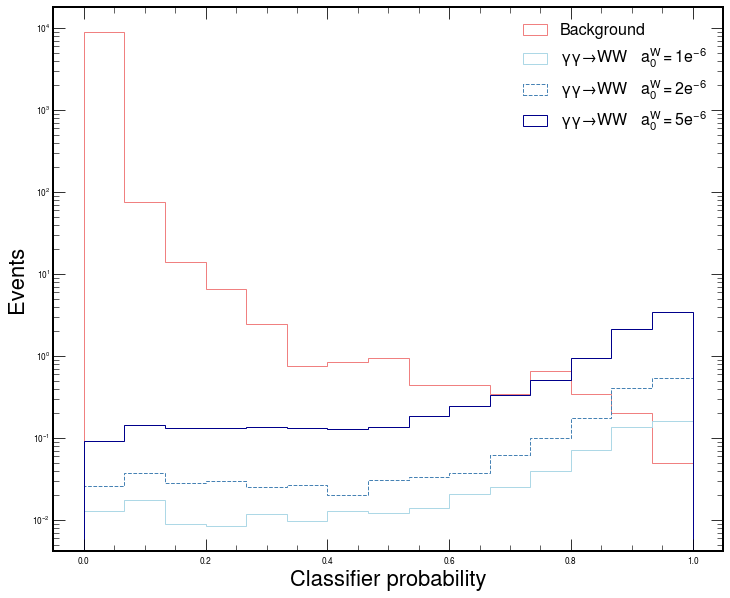

In [24]:
fig = plt.figure( figsize=(12,10) )

var_ = "probability"
hist_bins_ = 15
hist_range_ = (0.,1.)

labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

labels_ = [ "Background" ]
mc_list_var = [
    df_protons_multiRP_bkg_events[ var_ ]
    ]
weights_mc = [
    df_protons_multiRP_bkg_events["norm"]
    ]
for label_ in labels_signals:
    mc_list_var.append( df_signals_protons_multiRP_events[ label_ ][ var_ ] )
    weights_mc.append( ( df_signals_protons_multiRP_events[ label_ ]["norm"] * df_signals_protons_multiRP_events[ label_ ]["eff_all_weighted"] ) )
    labels_.append( labels_samples[ label_ ] )
colors_ = [ "lightcoral", "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "-", "--", "-"]

for idx_ in range( len( mc_list_var ) ):
    plt.hist( mc_list_var[ idx_ ], weights=weights_mc[ idx_ ], histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ],
              bins=hist_bins_, range=hist_range_, label=labels_[ idx_ ] )

# plt.hist( df_protons_multiRP_signal_events[ var_ ], histtype='step', color='skyblue', bins=hist_bins_, range=hist_range_,
#                                                     weights=( df_protons_multiRP_signal_events["norm"] * df_protons_multiRP_signal_events["eff_all_weighted"] ) )
plt.yscale('log')
plt.xlabel( "Classifier probability", fontsize=22 )
plt.ylabel( "Events", fontsize=22 )
plt.legend( fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Background_vs_Signals_Normalized_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Background_vs_Signals_Normalized_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

y max. = 11365.9
y max. = 643.5


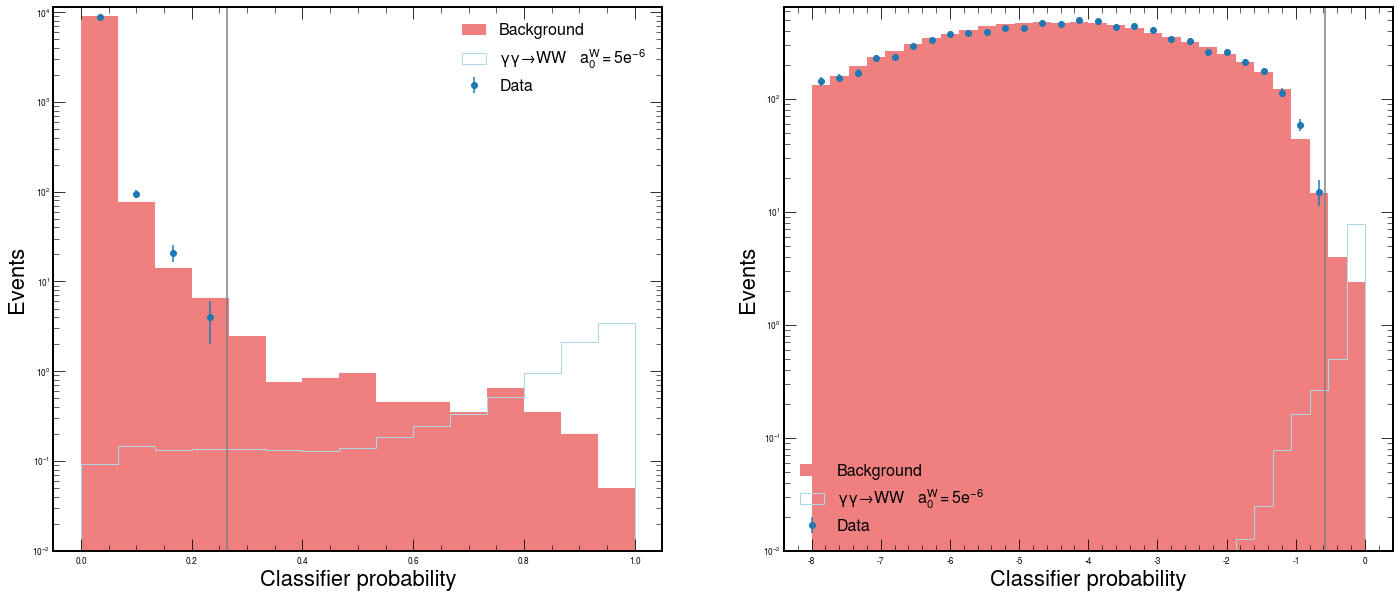

In [25]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

label_signal = "GGToWW-AQGC-A0W5e-6"

var_ = "probability"

hist_bins_ = 15
hist_range_ = (0.,1.)

counts_, bin_edges_ = np.histogram( df_protons_multiRP_data_events_bkgreg[ var_ ], bins=hist_bins_, range=hist_range_ )
errors_ = np.sqrt( counts_ )
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
idx_ymax_ = np.argmax( counts_ )
y_max = counts_[idx_ymax_]
y_max += np.max( [ 2 * errors_[idx_ymax_], 0.30*y_max ] )
print ( "y max. = {}".format(y_max) )

axes[0].hist( df_protons_multiRP_bkg_events[ var_ ], bins=hist_bins_, range=hist_range_, color='lightcoral', weights=df_protons_multiRP_bkg_events[ "norm" ], label="Background" )
axes[0].hist( df_signals_protons_multiRP_events[ label_signal ][ var_ ], bins=hist_bins_, range=hist_range_, color='lightblue', histtype='step',
                                                                     weights=( df_signals_protons_multiRP_events[ label_signal ]["norm"] * df_signals_protons_multiRP_events[ label_signal ]["eff_all_weighted"] ),
                                                                     label=labels_samples[ label_signal ] )
axes[0].errorbar( bin_centres_, counts_, yerr=errors_, fmt='o', label="Data" )

y_min = 1e-02
axes[0].set_ylim( bottom=y_min, top=y_max )
axes[0].plot( (prob_cut,prob_cut), (y_min,y_max), color='gray' )
axes[0].set_yscale('log')
axes[0].set_xlabel( "Classifier probability", fontsize=22 )
axes[0].set_ylabel( "Events", fontsize=22 )
axes[0].legend( fontsize=16 )

hist_bins_ = 30
hist_range_ = (-8.,0.)

counts_, bin_edges_ = np.histogram( np.log10( df_protons_multiRP_data_events_bkgreg[ var_ ] ), bins=hist_bins_, range=hist_range_ )
errors_ = np.sqrt( counts_ )
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
idx_ymax_ = np.argmax( counts_ )
y_max = counts_[idx_ymax_]
y_max += np.max( [ 2 * errors_[idx_ymax_], 0.30*y_max ] )
print ( "y max. = {}".format(y_max) )

axes[1].hist( np.log10( df_protons_multiRP_bkg_events[ var_ ] ), bins=hist_bins_, range=hist_range_, color='lightcoral', weights=df_protons_multiRP_bkg_events[ "norm" ], label="Background" )
axes[1].hist( np.log10( df_signals_protons_multiRP_events[ label_signal ][ var_ ] ), bins=hist_bins_, range=hist_range_, color='lightblue', histtype='step',
                                                                     weights=( df_signals_protons_multiRP_events[ label_signal ]["norm"] * df_signals_protons_multiRP_events[ label_signal ]["eff_all_weighted"] ),
                                                                     label=labels_samples[ label_signal ] )
axes[1].errorbar( bin_centres_, counts_, yerr=errors_, fmt='o', label="Data" )

y_min = 1e-02
axes[1].set_ylim( bottom=y_min, top=y_max )
axes[1].plot( ( np.log10(prob_cut), np.log10(prob_cut) ), ( y_min, y_max ), color='gray' )
axes[1].set_yscale('log')
axes[1].set_xlabel( "Classifier probability", fontsize=22 )
axes[1].set_ylabel( "Events", fontsize=22 )
axes[1].legend( fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Data_vs_Background_vs_Signal_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Data_vs_Background_vs_Signal_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

Number of events: 9104.100000000004
Number of events (A): 968.7500000000001
Number of events (B): 2532.6000000000004
Number of events (C): 1426.1000000000001
Number of events (D): 4176.65


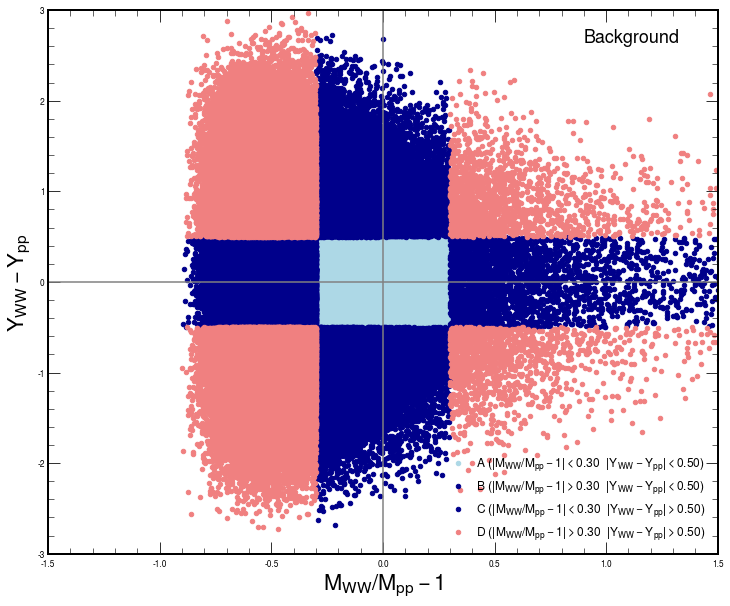

In [26]:
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg   = np.sum( df_protons_multiRP_bkg_events[ "norm" ] )
n_events_bkg_A = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_A ][ "norm" ] )
n_events_bkg_B = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_B ][ "norm" ] )
n_events_bkg_C = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_C ][ "norm" ] )
n_events_bkg_D = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_D ][ "norm" ] )

print ( "Number of events: {}".format( n_events_bkg ) )
print ( "Number of events (A): {}".format( n_events_bkg_A ) )
print ( "Number of events (B): {}".format( n_events_bkg_B ) )
print ( "Number of events (C): {}".format( n_events_bkg_C ) )
print ( "Number of events (D): {}".format( n_events_bkg_D ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
label_str_ = r"A ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue', label=label_str_ )
label_str_ = r"B ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"C ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"D ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=12 )
ax.text( 0.80, 0.95, "Background", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

Number of events: 9096.350000000004
Number of events (A): 962.8500000000001
Number of events (B): 2531.0000000000005
Number of events (C): 1425.9
Number of events (D): 4176.6


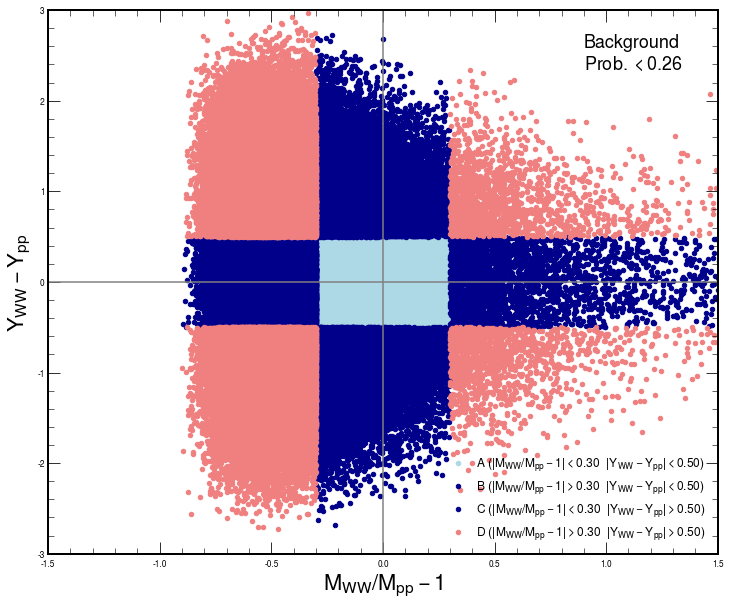

In [27]:
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events_bkgreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events_bkgreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg_bkgreg   = np.sum( df_protons_multiRP_bkg_events_bkgreg[ "norm" ] )
n_events_bkg_bkgreg_A = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_A ][ "norm" ] )
n_events_bkg_bkgreg_B = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_B ][ "norm" ] )
n_events_bkg_bkgreg_C = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_C ][ "norm" ] )
n_events_bkg_bkgreg_D = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_D ][ "norm" ] )

print ( "Number of events: {}".format( n_events_bkg_bkgreg ) )
print ( "Number of events (A): {}".format( n_events_bkg_bkgreg_A ) )
print ( "Number of events (B): {}".format( n_events_bkg_bkgreg_B ) )
print ( "Number of events (C): {}".format( n_events_bkg_bkgreg_C ) )
print ( "Number of events (D): {}".format( n_events_bkg_bkgreg_D ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
label_str_ = r"A ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue', label=label_str_ )
label_str_ = r"B ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"C ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"D ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=12 )
title_str_ = "Background\n$\\rm{{Prob.}} < {:.2f}$".format( prob_cut )
title_str_ = r"{}".format( title_str_ )
ax.text( 0.80, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

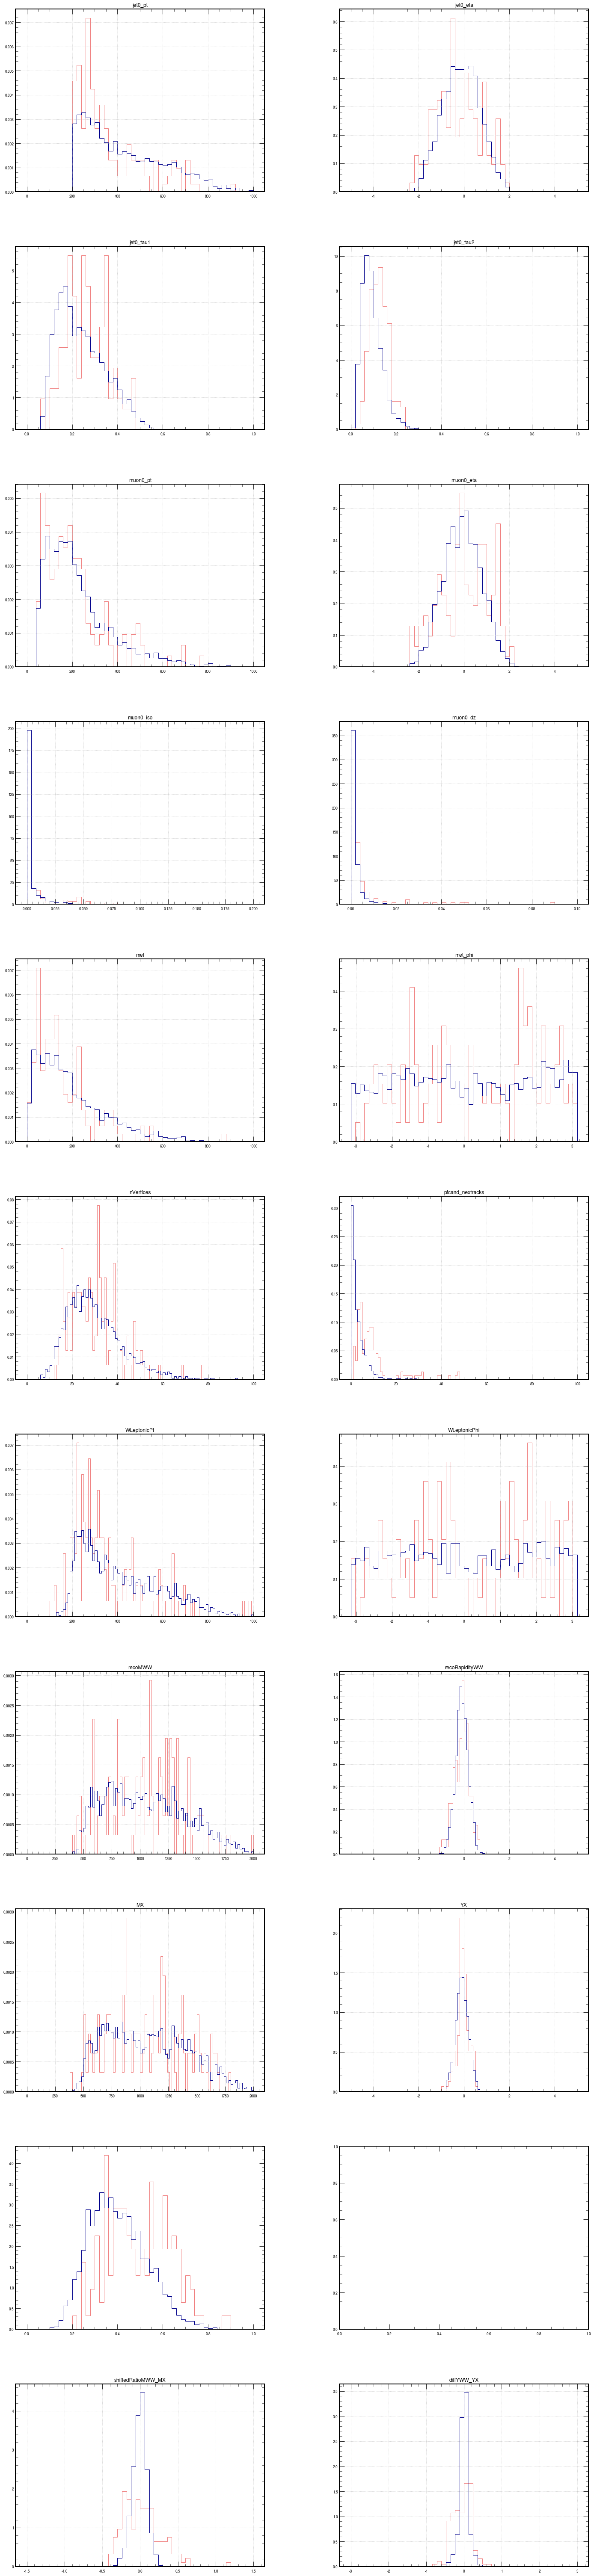

In [28]:
label_signal = "GGToWW-AQGC-A0W1e-6"

fig, axes = plt.subplots( 11, 2, figsize=(24,11*10) )

row_ = 0
df_protons_multiRP_bkg_events_sigreg.hist( "jet0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "jet0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "jet0_tau1", bins=50, range=(0.,1.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_tau1", bins=50, range=(0.,1.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "jet0_tau2", bins=50, range=(0.,1.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_tau2", bins=50, range=(0.,1.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_iso", bins=50, range=(0.,0.2), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_iso", bins=50, range=(0.,0.2), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_dz", bins=50, range=(0.,0.1), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_dz", bins=50, range=(0.,0.1), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "met", bins=50, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "met", bins=50, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "met_phi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "met_phi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "nVertices", bins=100, range=(0.,100.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "nVertices", bins=100, range=(0.,100.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "pfcand_nextracks", bins=100, range=(0.,100.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "pfcand_nextracks", bins=100, range=(0.,100.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "WLeptonicPt", bins=100, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "WLeptonicPt", bins=100, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "WLeptonicPhi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "WLeptonicPhi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "recoMWW", bins=100, range=(0.,2000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "recoMWW", bins=100, range=(0.,2000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "recoRapidityWW", bins=100, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "recoRapidityWW", bins=100, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "MX", bins=100, range=(0.,2000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "MX", bins=100, range=(0.,2000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "YX", bins=100, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "YX", bins=100, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

axes[row_,0].hist( ( df_protons_multiRP_bkg_events_sigreg[ "jet0_tau2" ] / df_protons_multiRP_bkg_events_sigreg[ "jet0_tau1" ] ), bins=50, range=(0.,1.), histtype="step", density=True, color="lightcoral" )
axes[row_,0].hist( ( df_signals_protons_multiRP_events_sigreg[ label_signal ][ "jet0_tau2" ] / df_signals_protons_multiRP_events_sigreg[ label_signal ][ "jet0_tau1" ] ), bins=50, range=(0.,1.), histtype="step", density=True, color="darkblue" )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "shiftedRatioMWW_MX", bins=50, range=(-1.5,1.5), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "shiftedRatioMWW_MX", bins=50, range=(-1.5,1.5), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "diffYWW_YX", bins=50, range=(-3.,3.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "diffYWW_YX", bins=50, range=(-3.,3.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1


Number of events: 7.749999999999999 +/- 0.6224949798994367
Number of events (A): 5.8999999999999995 +/- 0.543139024560011
Number of events (B): 1.6 +/- 0.28284271247461906
Number of events (C): 0.2 +/- 0.1
Number of events (D): 0.05 +/- 0.05


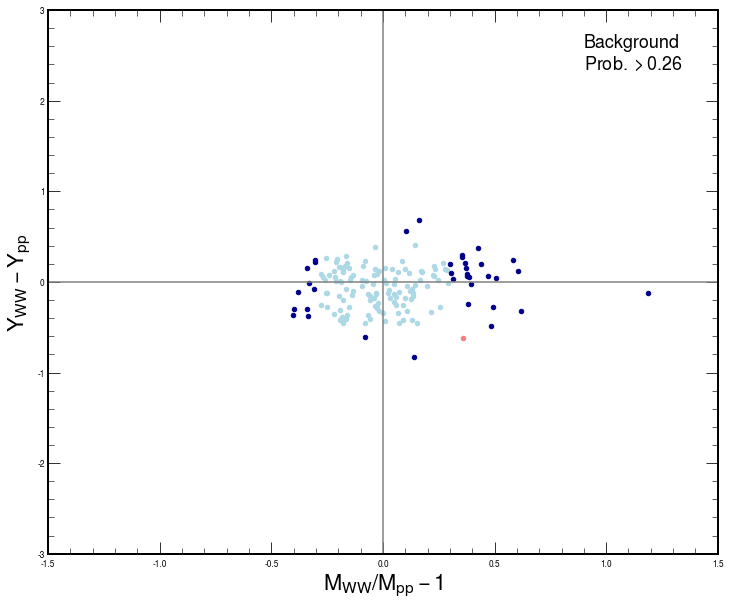

In [29]:
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events_sigreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events_sigreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg_sigreg   = np.sum( df_protons_multiRP_bkg_events_sigreg[ "norm" ] )
err_n_events_bkg_sigreg = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ "norm" ] ) ) )
n_events_bkg_sigreg_A = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_A ][ "norm" ] )
err_n_events_bkg_sigreg_A = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_A ][ "norm" ] ) ) )
n_events_bkg_sigreg_B = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_B ][ "norm" ] )
err_n_events_bkg_sigreg_B = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_B ][ "norm" ] ) ) )
n_events_bkg_sigreg_C = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_C ][ "norm" ] )
err_n_events_bkg_sigreg_C = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_C ][ "norm" ] ) ) )
n_events_bkg_sigreg_D = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_D ][ "norm" ] )
err_n_events_bkg_sigreg_D = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_D ][ "norm" ] ) ) )

print ( "Number of events: {} +/- {}".format( n_events_bkg_sigreg, err_n_events_bkg_sigreg ) )
print ( "Number of events (A): {} +/- {}".format( n_events_bkg_sigreg_A, err_n_events_bkg_sigreg_A ) )
print ( "Number of events (B): {} +/- {}".format( n_events_bkg_sigreg_B, err_n_events_bkg_sigreg_B ) )
print ( "Number of events (C): {} +/- {}".format( n_events_bkg_sigreg_C, err_n_events_bkg_sigreg_C ) )
print ( "Number of events (D): {} +/- {}".format( n_events_bkg_sigreg_D, err_n_events_bkg_sigreg_D ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
if np.sum( msk_bkg_A ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue' )
if np.sum( msk_bkg_B ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
if np.sum( msk_bkg_C ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
if np.sum( msk_bkg_D ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral' )
title_str_ = "Background\n$\\rm{{Prob.}} > {:.2f}$".format( prob_cut )
title_str_ = r"{}".format( title_str_ )
ax.text( 0.80, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

GGToWW-AQGC-A0W1e-6
Number of events: 4.098115824908946 +/- 0.011231333563539083
Number of events (A): 4.086222453941135 +/- 0.011215141863370423
Number of events (B): 0.008495264977008596 +/- 0.0005660301283345891
Number of events (C): 0.003398105990803438 +/- 0.00020750058740460952
Number of events (D): 0.0 +/- 0.0
0 0
GGToWW-AQGC-A0W2e-6
Number of events: 10.723187091648798 +/- 0.023223915691123465
Number of events (A): 10.668967345379833 +/- 0.023162829525879718
Number of events (B): 0.044361610583699924 +/- 0.001548039903406013
Number of events (C): 0.007393601763949988 +/- 0.0005578246938443739
Number of events (D): 0.002464533921316663 +/- 0.00035495415456865924
0 1
GGToWW-AQGC-A0W5e-6
Number of events: 58.25325152996464 +/- 0.08414202089733878
Number of events (A): 58.031334381279066 +/- 0.08398498424337379
Number of events (B): 0.19972543381702165 +/- 0.00485703053075535
Number of events (C): 0.01664378615141847 +/- 0.0014670899005451326
Number of events (D): 0.005547928717139

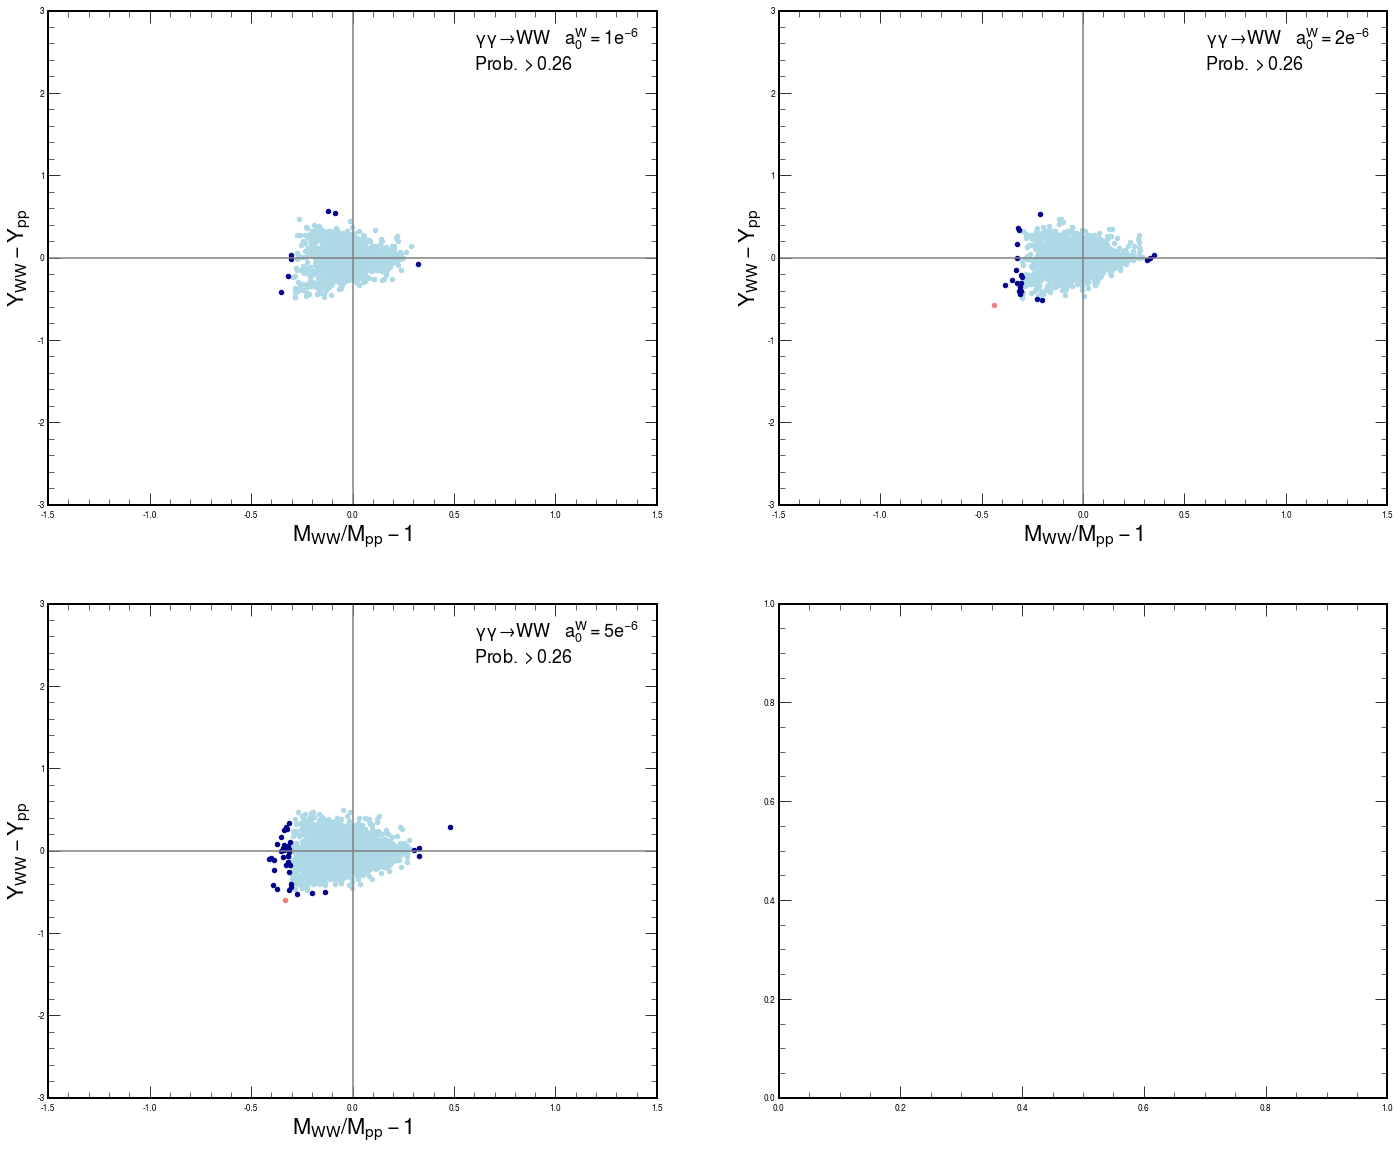

In [30]:
#label_signal = "GGToWW-AQGC-test-A0W5e-6"

nrows_ = ( int( len(labels_signals)/2 ) + 1 if ( len(labels_signals) % 2 ) > 0 else  int( len(labels_signals)/2 ) )
fig, axes = plt.subplots( nrows_, 2, figsize=(24,nrows_*10) )

row_ = 0
col_ = 0
for label_ in labels_signals:
    print ( label_ )
    
    msk_sig_cut1 = ( np.abs( df_signals_protons_multiRP_events_sigreg[ label_ ][ "shiftedRatioMWW_MX" ] ) <= 0.30 )
    msk_sig_cut2 = ( np.abs( df_signals_protons_multiRP_events_sigreg[ label_ ][ "diffYWW_YX" ] ) <= 0.50 )
    msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2
    msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2
    msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2
    msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2

    n_events_sig   = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ "norm" ] )
    err_n_events_sig = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ "norm" ] *
                                                   df_signals_protons_multiRP_events_sigreg[ label_ ]["eff_all_weighted"] ) ) )
    n_events_sig_A = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ][ "norm" ] )
    err_n_events_sig_A = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ]["eff_all_weighted"] ) ) )
    n_events_sig_B = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ][ "norm" ] )
    err_n_events_sig_B = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ]["eff_all_weighted"] ) ) )
    n_events_sig_C = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ][ "norm" ] )
    err_n_events_sig_C = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ]["eff_all_weighted"] ) ) )
    n_events_sig_D = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ][ "norm" ] )
    err_n_events_sig_D = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ]["eff_all_weighted"] ) ) )

    print ( "Number of events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of events (A): {} +/- {}".format( n_events_sig_A, err_n_events_sig_A ) )
    print ( "Number of events (B): {} +/- {}".format( n_events_sig_B, err_n_events_sig_B ) )
    print ( "Number of events (C): {} +/- {}".format( n_events_sig_C, err_n_events_sig_C ) )
    print ( "Number of events (D): {} +/- {}".format( n_events_sig_D, err_n_events_sig_D ) )

    x_min = -1.5
    x_max =  1.5
    y_min = -3.0
    y_max =  3.0
    x_center = ( x_min + x_max ) / 2.
    y_center = ( y_min + y_max ) / 2.

    print ( row_, col_ )
    axes[ row_, col_ ].plot( (x_min,x_max), (y_center,y_center), color='gray' )
    axes[ row_, col_ ].plot( (x_center,x_center), (y_min,y_max), color='gray' )
    if np.sum( msk_sig_A ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='lightblue' )
    if np.sum( msk_sig_B ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='darkblue' )
    if np.sum( msk_sig_C ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='darkblue' )
    if np.sum( msk_sig_D ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='lightcoral' )
    title_str_ = "{}\n$\\rm{{Prob.}} > {:.2f}$".format( labels_samples[ label_ ], prob_cut )
    title_str_ = r"{}".format( title_str_ )
    axes[ row_, col_ ].text( 0.70, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=axes[ row_, col_ ].transAxes, fontsize=18 )
    axes[ row_, col_ ].set_xlim(x_min, x_max)
    axes[ row_, col_ ].set_ylim(y_min, y_max)
    axes[ row_, col_ ].set_xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
    axes[ row_, col_ ].set_ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
    col_ += 1
    if col_ >= 2:
        row_ += 1
        col_  = 0

if save_figures:        
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Signals_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Signals_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

Text(0, 0.5, '$Y_{WW} - Y_{pp}$')

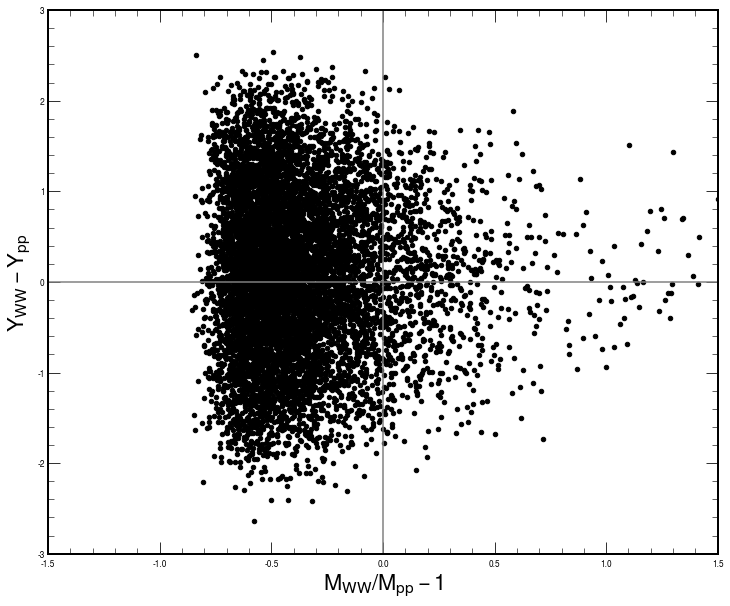

In [31]:
x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
df_protons_multiRP_data_events_bkgreg.plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='black' )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )

Number of events: 8863 - Ratio: 0.9743468534082348
Number of events (A): 1020 - Ratio: 1.0593550397258138
Number of events (B): 2460 - Ratio: 0.9719478467009085
Number of events (C): 1394 - Ratio: 0.977628164667929
Number of events (D): 3989 - Ratio: 0.9550830819326724


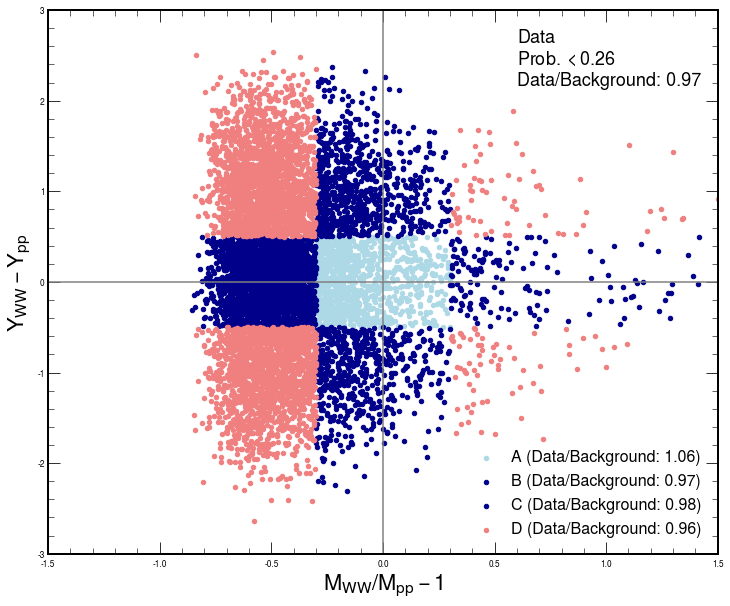

In [32]:
msk_data_cut1 = ( np.abs( df_protons_multiRP_data_events_bkgreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_data_cut2 = ( np.abs( df_protons_multiRP_data_events_bkgreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_data_A =  msk_data_cut1 &  msk_data_cut2
msk_data_B = ~msk_data_cut1 &  msk_data_cut2
msk_data_C =  msk_data_cut1 & ~msk_data_cut2
msk_data_D = ~msk_data_cut1 & ~msk_data_cut2

n_events_data_bkgreg = df_protons_multiRP_data_events_bkgreg.shape[0]
n_events_data_bkgreg_A = df_protons_multiRP_data_events_bkgreg[ msk_data_A ].shape[0]
n_events_data_bkgreg_B = df_protons_multiRP_data_events_bkgreg[ msk_data_B ].shape[0]
n_events_data_bkgreg_C = df_protons_multiRP_data_events_bkgreg[ msk_data_C ].shape[0]
n_events_data_bkgreg_D = df_protons_multiRP_data_events_bkgreg[ msk_data_D ].shape[0]

print ( "Number of events: {} - Ratio: {}".format( n_events_data_bkgreg, ( n_events_data_bkgreg / ( n_events_bkg_bkgreg ) ) ) )
print ( "Number of events (A): {} - Ratio: {}".format( n_events_data_bkgreg_A, ( n_events_data_bkgreg_A / ( n_events_bkg_bkgreg_A ) ) ) )
print ( "Number of events (B): {} - Ratio: {}".format( n_events_data_bkgreg_B, ( n_events_data_bkgreg_B / ( n_events_bkg_bkgreg_B ) ) ) )
print ( "Number of events (C): {} - Ratio: {}".format( n_events_data_bkgreg_C, ( n_events_data_bkgreg_C / ( n_events_bkg_bkgreg_C ) ) ) )
print ( "Number of events (D): {} - Ratio: {}".format( n_events_data_bkgreg_D, ( n_events_data_bkgreg_D / ( n_events_bkg_bkgreg_D ) ) ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
label_str_ = "A (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_A / ( n_events_bkg_bkgreg_A ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue', label=label_str_ )
label_str_ = "B (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_B / ( n_events_bkg_bkgreg_B ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = "C (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_C / ( n_events_bkg_bkgreg_C ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = "D (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_D / ( n_events_bkg_bkgreg_D ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=16 )
# title_str_ = "Data\n$\\rm{{Prob.}} < {:.2f} \;\\rm{{-}}\; {:.0f}\%$ ({})".format(
#     prob_cut, 100*eff_signals_prob_cut[ "GGToWW-AQGC-test-A0W1e-6" ], labels_samples[ "GGToWW-AQGC-test-A0W1e-6" ] )
title_str_ = "Data\n$\\rm{{Prob.}} < {:.2f}$\nData/Background: {:.2f}".format( prob_cut, ( n_events_data_bkgreg / ( n_events_bkg_bkgreg ) ) )
title_str_ = r"{}".format( title_str_ )
# leg_ = plt.legend( loc='best', fontsize=16 )
# leg_.set_title( title_str_, prop={'size': 16} )
# leg_._legend_box.align = "right"
ax.text( 0.70, 0.91, title_str_, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Data_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Data_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

In [33]:
# msk_data = ( df_protons_multiRP_data_events[ "probability" ] >= 0.01 )
# df_protons_multiRP_data_events_signal = df_protons_multiRP_data_events.loc[ msk_data ]

# msk_data_cut1 = ( np.abs( df_protons_multiRP_data_events_signal[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
# msk_data_cut2 = ( np.abs( df_protons_multiRP_data_events_signal[ "diffYWW_YX" ] ) <= 0.50 )
# msk_data_A =  msk_data_cut1 &  msk_data_cut2
# msk_data_B = ~msk_data_cut1 &  msk_data_cut2
# msk_data_C =  msk_data_cut1 & ~msk_data_cut2
# msk_data_D = ~msk_data_cut1 & ~msk_data_cut2

# n_events_data = df_protons_multiRP_data_events_signal.shape[0]
# n_events_data_A = df_protons_multiRP_data_events_signal[ msk_data_A ].shape[0]
# n_events_data_B = df_protons_multiRP_data_events_signal[ msk_data_B ].shape[0]
# n_events_data_C = df_protons_multiRP_data_events_signal[ msk_data_C ].shape[0]
# n_events_data_D = df_protons_multiRP_data_events_signal[ msk_data_D ].shape[0]

# print ( "Number of events: {}".format( n_events_data ) )
# print ( "Number of events (A): {}".format( n_events_data_A ) )
# print ( "Number of events (B): {}".format( n_events_data_B ) )
# print ( "Number of events (C): {}".format( n_events_data_C ) )
# print ( "Number of events (D): {}".format( n_events_data_D ) )

# x_min = -1.5
# x_max =  1.5
# y_min = -3.0
# y_max =  3.0
# x_center = ( x_min + x_max ) / 2.
# y_center = ( y_min + y_max ) / 2.

# fig = plt.figure( figsize=(12,10) )
# plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
# plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
# ax = plt.gca()
# df_protons_multiRP_data_events_signal[ msk_data_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue' )
# df_protons_multiRP_data_events_signal[ msk_data_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
# df_protons_multiRP_data_events_signal[ msk_data_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
# df_protons_multiRP_data_events_signal[ msk_data_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral' )
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)